# Analysis combined of different algorithms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [3]:
# load numpy arrays from files
devrl_returns = np.load('DevRL/BG_NOISE/overall_returns.npy')
devrl_params = np.load('DevRL/BG_NOISE/parameter_values.npy')

dual_pathway_returns = np.load('Dual_Pathway/BG_NOISE/overall_returns.npy')
dual_pathway_params = np.load('Dual_Pathway/BG_NOISE/parameter_values.npy') 

stdrl_returns = np.load('std_RL/BG_NOISE/overall_returns.npy')
stdrl_params = np.load('std_RL/BG_NOISE/parameter_values.npy')

simannealing_returns = np.load('Sim_Annealing/NOISE/overall_returns_1.npy')
simannealing_params = np.load('Sim_Annealing/NOISE/parameter_values_1.npy')


In [4]:
def plot_results(returns, params, label):
    returns = np.array(returns) * 100
    sorted_params = sorted(params)
    # print(sorted_params)    
    sorted_indices = np.argsort(params)

    returns = returns[:,sorted_indices]
    above_threshold = np.zeros(len(params))
    for i in range(len(params)):
        above_threshold[i] = np.sum(returns[:,i] > 70)
    plt.bar(range(len(params)), 100*above_threshold/len(returns), color='blue', alpha=0.5)
    for i in range(len(params)):
        plt.plot(i * np.ones_like(returns[:,i]), returns[:,i], 'o', color='black', markersize=0.5, alpha = 0.2)
        plt.text(i, 100*above_threshold[i]/len(returns), f"{100*above_threshold[i]/len(returns):.1f}%", ha='center', va='bottom')
    plt.xlabel('Parameter set')        
    plt.hlines(70, 0, len(params), colors='r', linestyles='dashed')
    plt.xticks(np.arange(len(params), step=1), labels=sorted_params)
    plt.ylabel('Percentage of runs above 70%')  
    plt.ylim(0, 100)
    plt.title(f"Variability of performance for {label} with noise") 
    plt.legend()    
    plt.show()  






C:\Users\Dell\AppData\Local\Temp\ipykernel_12740\3992948094.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


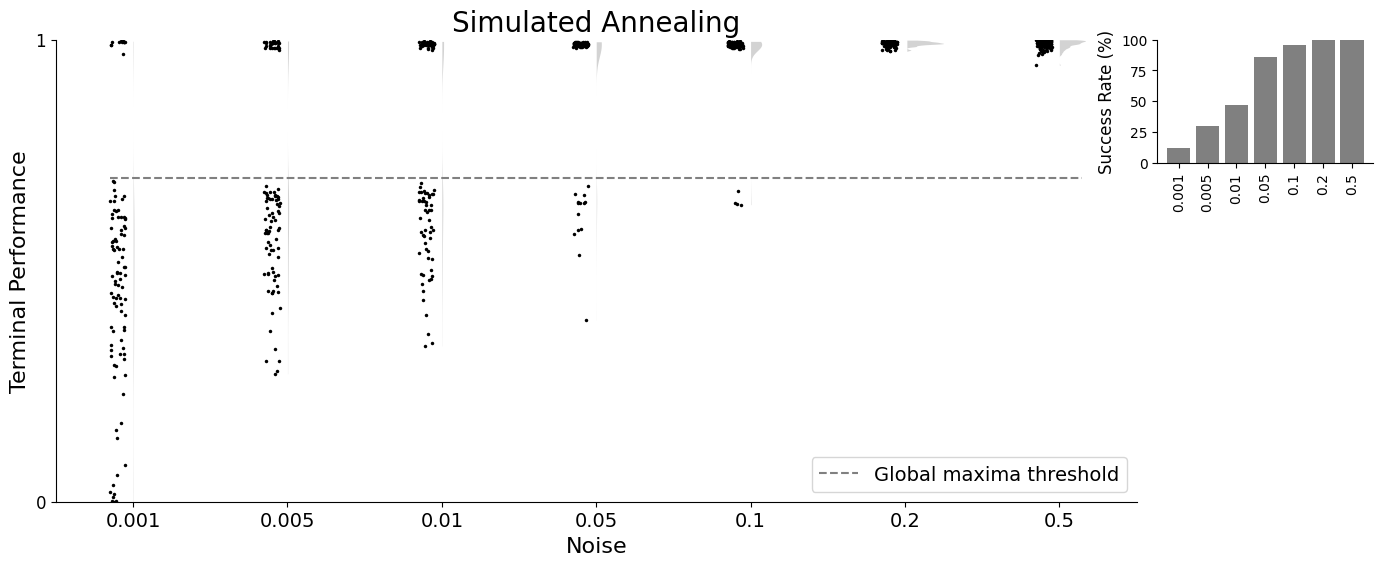

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches

color_violin = 'lightgray'
color_bar = 'grey'
color_strip = 'black'

def plot_results_violin(returns, params, label, xlabels=None, title=None):
    returns = np.array(returns) * 100  # Convert to percentage
    sorted_params = sorted(params)
    sorted_indices = np.argsort(params)
    
    returns = returns[:, sorted_indices]
    sorted_params = np.array(params)[sorted_indices]

    n_values = len(sorted_params)
    above_threshold = np.zeros(n_values)
    
    data = []
    labels_list = []

    for i in range(n_values):
        col = returns[:, i] / 100  # Convert back to [0, 1] scale
        above_threshold[i] = np.sum(col > 0.70) / len(col)
        data.extend(col)
        labels_list.extend([sorted_params[i]] * len(col))

    threshold = 0.70

    # Create figure with two subplots: violin and bar
    fig = plt.figure(figsize=(2 * n_values + 3, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[6, 1.2], height_ratios=[2, 5], wspace=0.2 - 0.12*n_values/5, hspace=0.15)

    # Violin plot (left)
    ax1 = fig.add_subplot(gs[:, 0])
    sns.violinplot(x=labels_list, y=data,
            inner=None, color=color_violin, linewidth=0,
            cut=0, ax=ax1, bw_adjust=0.5, width=0.5, density_norm='area')
    
    # Clip violins to right half
    for c in ax1.collections:
        if hasattr(c, "get_paths"):
            for path in c.get_paths():
                verts = path.vertices
                x_center = np.median(verts[:,0])
                verts[:,0] = np.where(verts[:,0] < x_center,
                                    x_center, verts[:,0])

    strip = sns.stripplot(x=labels_list, y=data, size=2.5, color=color_strip, alpha=1, jitter=0.05, ax=ax1)

    # Draw the threshold line
    ax1.axhline(threshold, 0.05, 0.95, color='grey', linestyle='--', label='Global maxima threshold')

    # # For each violin, color the above/below areas
    # for i, param in enumerate(sorted_params):
    #     col = returns[:, i] / 100
    #     positions = np.array([i] * len(col))
        
    #     # Create dummy violin for the outline
    #     v = ax1.violinplot(col, positions=[i], widths=0.8, showextrema=False)
    #     body = v['bodies'][0]
    #     path = body.get_paths()[0]

    #     # Two rectangles: below and above threshold
    #     r1 = matplotlib.patches.Rectangle(
    #         (i-0.4, 0), 0.8, threshold, facecolor='grey', alpha=1
    #     )
    #     r2 = matplotlib.patches.Rectangle(
    #         (i-0.4, threshold), 0.8, 1-threshold, facecolor=purples_last, alpha=1
    #     )
    #     r1.set_clip_path(path, transform=ax1.transData)
    #     r2.set_clip_path(path, transform=ax1.transData)
    #     ax1.add_patch(r1)
    #     ax1.add_patch(r2)

        # Add percentage annotations
        # ax1.text(i, 0.73, f"{100 * above_threshold[i]:.0f}%", ha='center', va='bottom', fontsize=13, color='red')

        # Optionally draw violin outline
        # outline = matplotlib.patches.PathPatch(path, linewidth=1, edgecolor="black", fill=False)
        # ax1.add_patch(outline)

    ax1.set_xlabel(label, fontsize=16)
    ax1.set_ylabel('Terminal Performance', fontsize=16)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels([0, 1], fontsize=12)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for coll in strip.collections:
        offsets = coll.get_offsets()
        new_offsets = []
        for x, y in offsets:
            new_offsets.append((x - 0.1, y))  # shift to the left
        coll.set_offsets(new_offsets)

    if xlabels is not None:
        ax1.set_xticks(range(n_values))
        ax1.set_xticklabels(xlabels, fontsize=14)
    else:
        ax1.set_xticks(range(n_values))
        ax1.set_xticklabels(sorted_params, fontsize=14)

    ax1.legend(loc='lower right', fontsize=14)
    if title:
        ax1.set_title(title, fontsize=20)

    # Bottom-right bar plot
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(range(n_values), above_threshold * 100, color=color_bar, alpha=1)
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Success Rate (%)', fontsize=12)
    ax2.set_xticks(range(n_values))
    ax2.set_xticklabels(xlabels, rotation=90, ha='right', va='center', fontsize=10, rotation_mode="anchor") if xlabels is not None else ax2.set_xticklabels(sorted_params, rotation=90, ha='center', fontsize=10)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_results_violin(simannealing_returns[:,np.argsort(simannealing_params)[:]], simannealing_params[np.argsort(simannealing_params)[:]], 'Noise', title='Simulated Annealing')  


C:\Users\Dell\AppData\Local\Temp\ipykernel_12740\3322151572.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


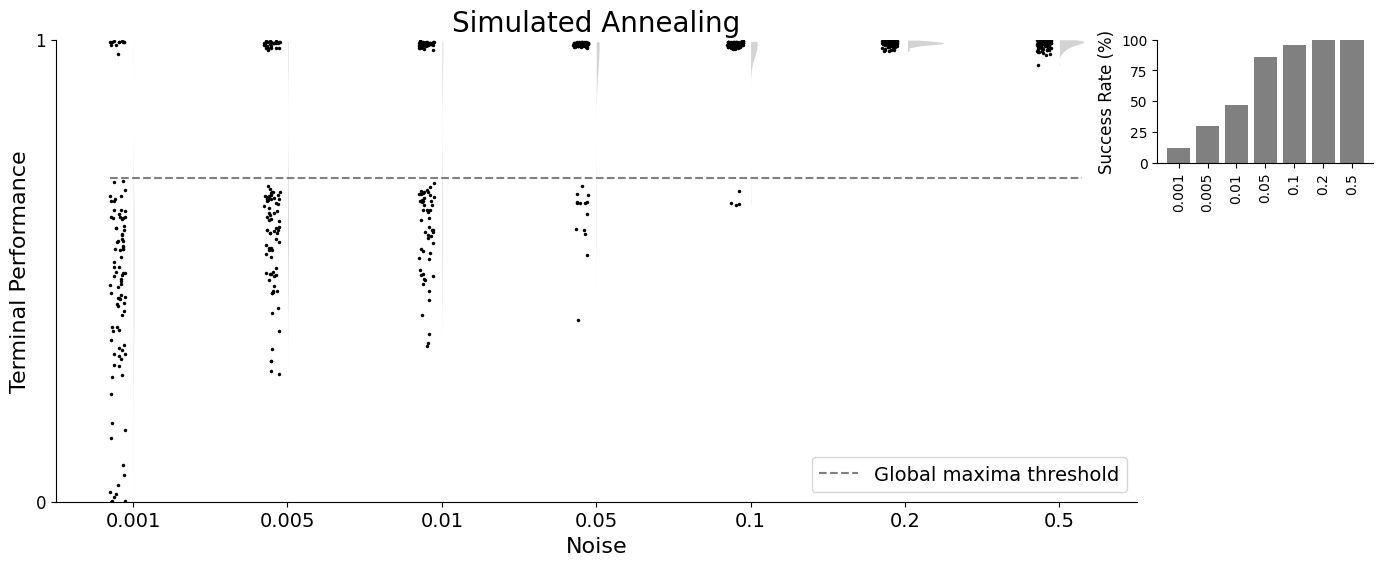

C:\Users\Dell\AppData\Local\Temp\ipykernel_12740\3322151572.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


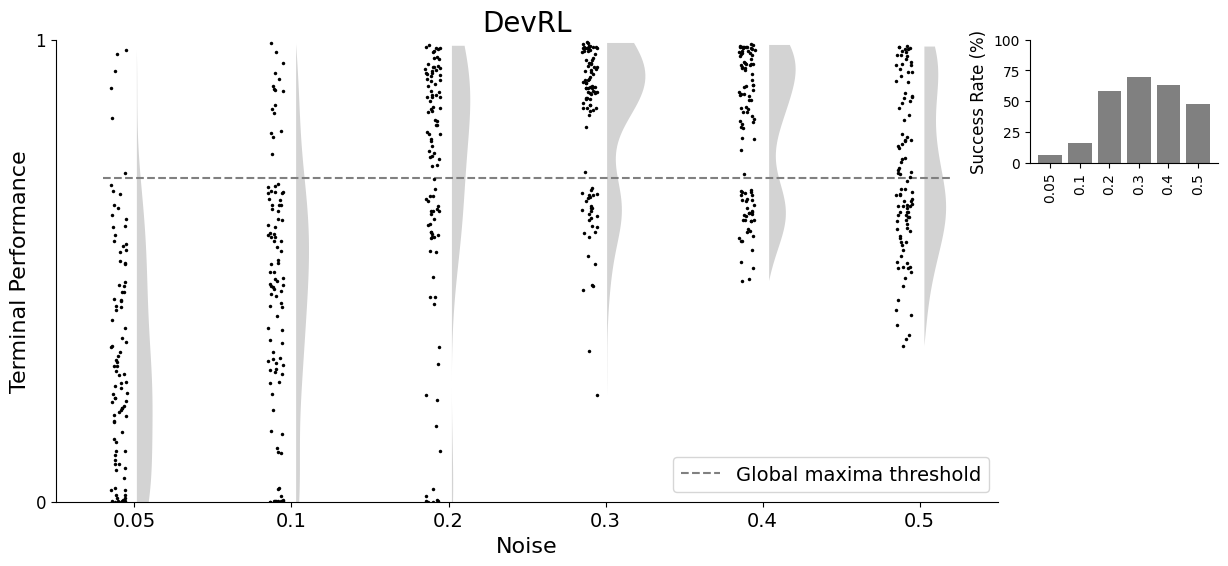

C:\Users\Dell\AppData\Local\Temp\ipykernel_12740\3322151572.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


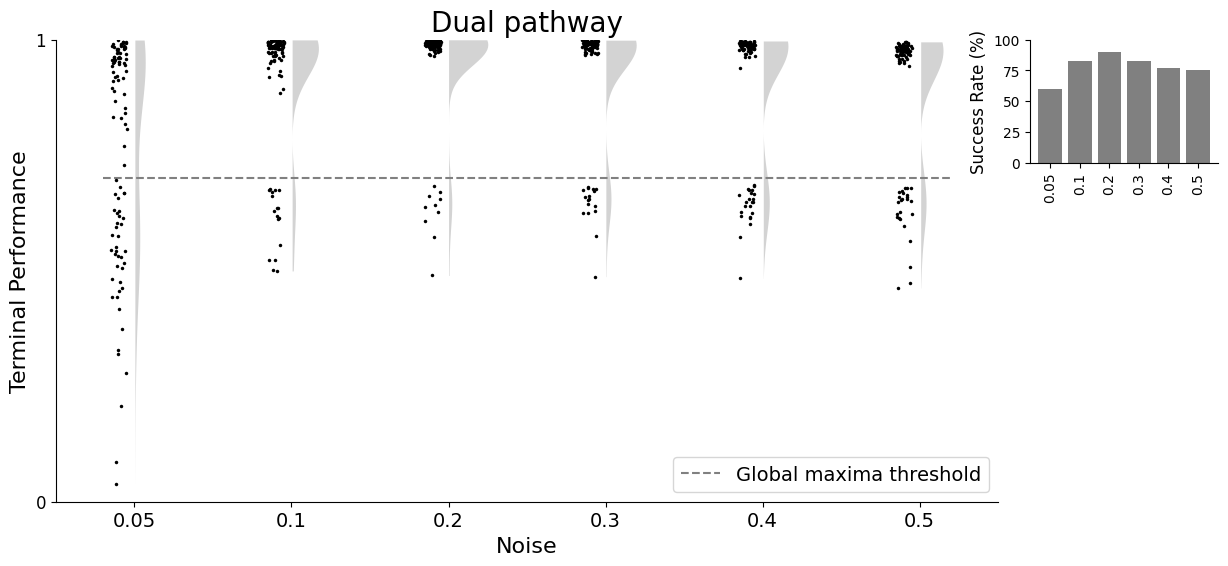

C:\Users\Dell\AppData\Local\Temp\ipykernel_12740\3322151572.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


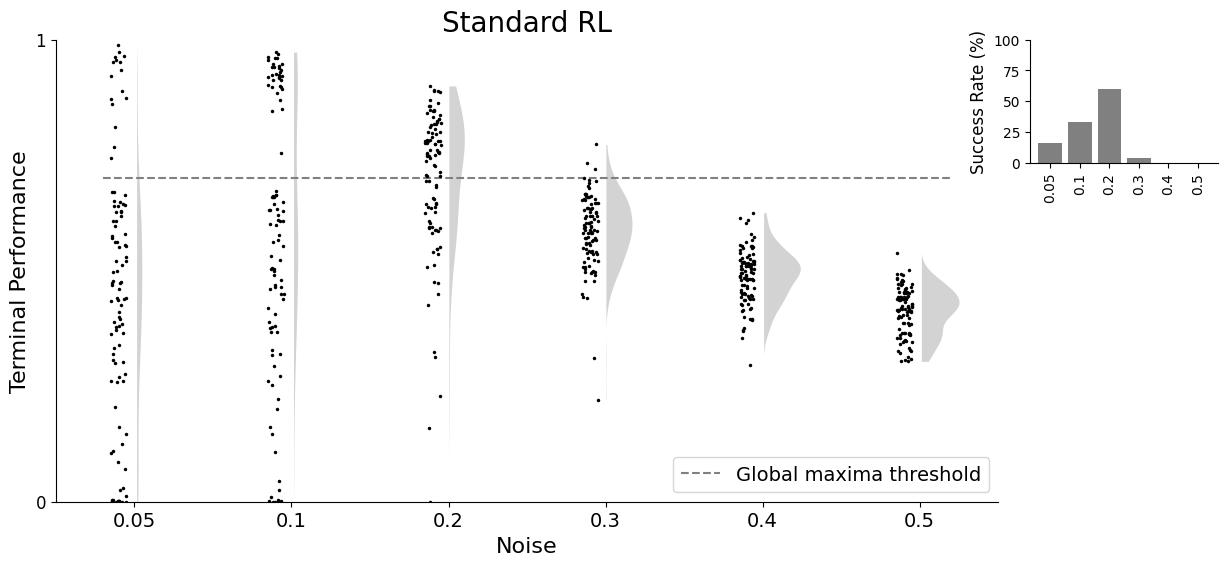

In [18]:
plot_results_violin(simannealing_returns[:,np.argsort(simannealing_params)[:]], simannealing_params[np.argsort(simannealing_params)[:]], 'Noise', title='Simulated Annealing')  
plot_results_violin(devrl_returns, devrl_params, 'Noise', title='DevRL')  
plot_results_violin(dual_pathway_returns, dual_pathway_params,'Noise', title= 'Dual pathway')
plot_results_violin(stdrl_returns, stdrl_params, 'Noise', title='Standard RL')
# plot_results_violin(simannealing_returns, simannealing_params,'Noise', title= 'Simulated Annealing')    

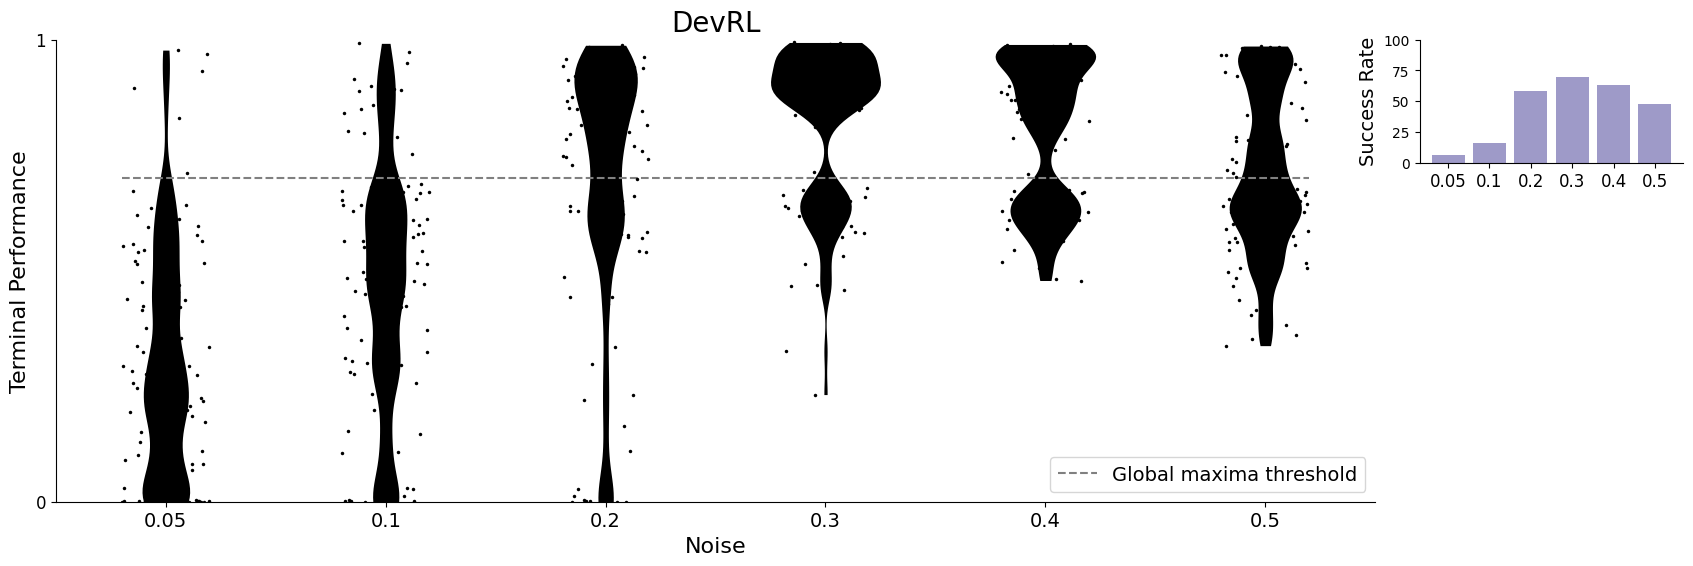

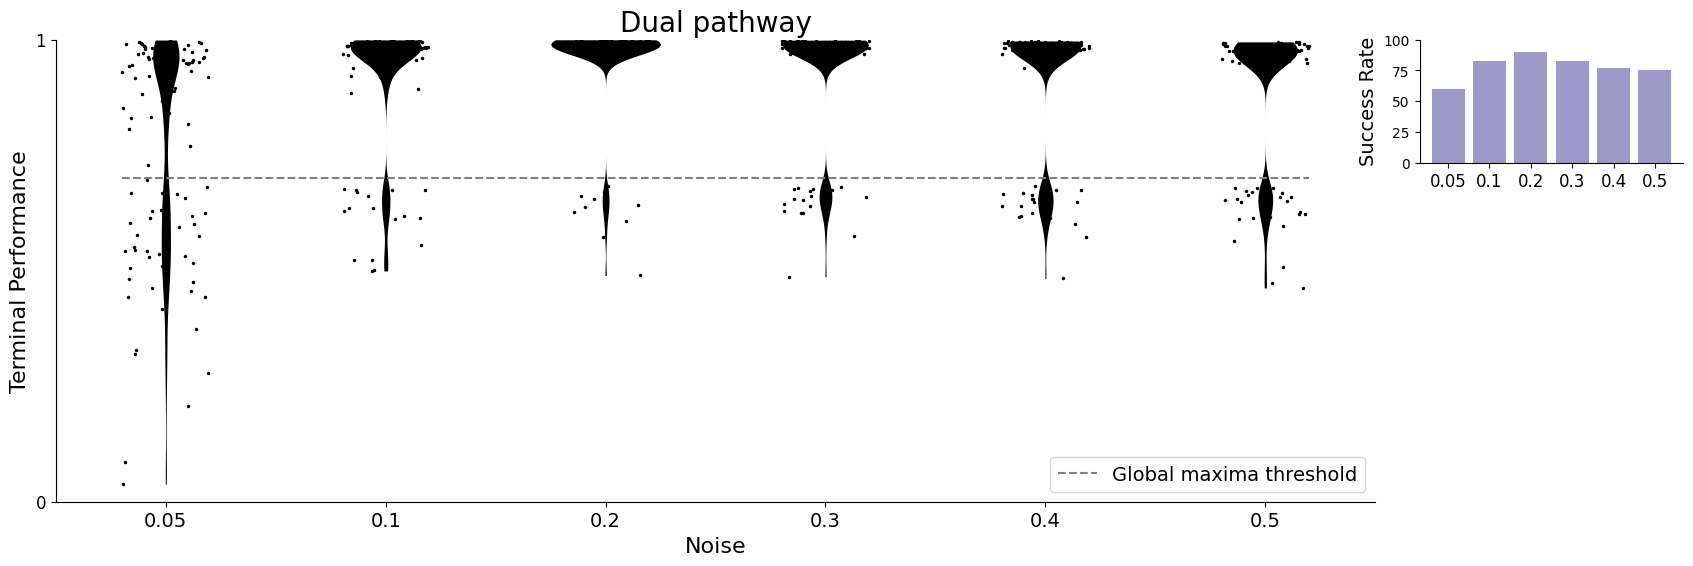

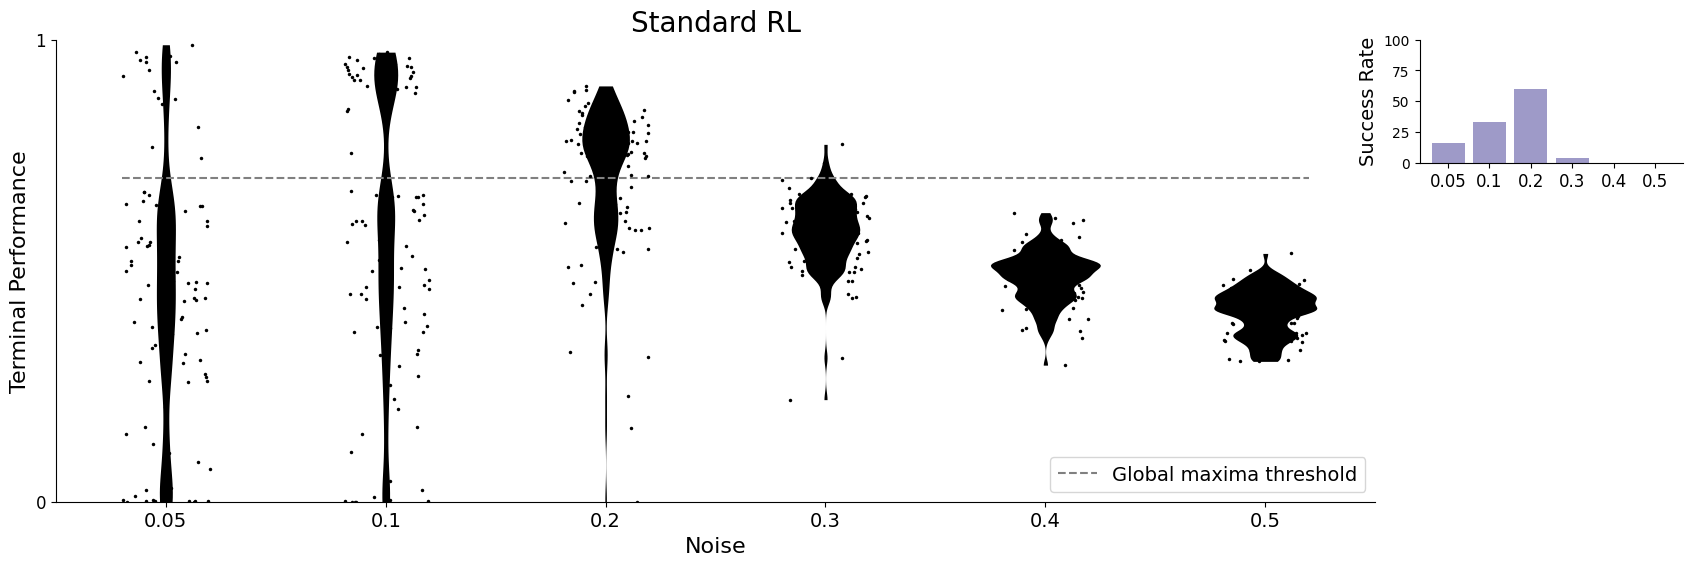

In [9]:
plot_results_violin(devrl_returns, devrl_params, 'Noise', title='DevRL')  
plot_results_violin(dual_pathway_returns, dual_pathway_params,'Noise', title= 'Dual pathway')
plot_results_violin(stdrl_returns, stdrl_params, 'Noise', title='Standard RL')
# plot_results_violin(simannealing_returns, simannealing_params,'Noise', title= 'Simulated Annealing')    